# Project: OpenStreetMap Data Analysis - Reims
**Author: **Nicolas Auber  
**Date: **24 November 2020  
## Table of Contents
<ul>
<li><a href="#introduction">1. Introduction</a></li>
<li><a href="#preparation">2. Data Preparation</a></li>
<li><a href="#wrangling">3. Data Wrangling</a></li>
<li><a href="#sql">4. SQL Database Creation</a></li>
<li><a href="#analysis">5. Data Analysis</a></li>
<li><a href="#conclusion">6. Conclusion</a></li>
</ul>

<a id='introduction'></a>
## 1. Introduction
Shortcut to chapters <a href='#introduction'>1</a>, <a href='#preparation'>2</a>, <a href='#wrangling'>3</a>, <a href='#sql'>4</a>, <a href='#analysis'>5</a> and <a href='#conclusion'>6</a>.  

This project is part of Airbus Data Analyst Nanodegree Progam. It will deal with the analysis of OpenStreetMap data focusing on Reims city in France. The reason is simple: Reims is my hometown and I am still curious about this city.

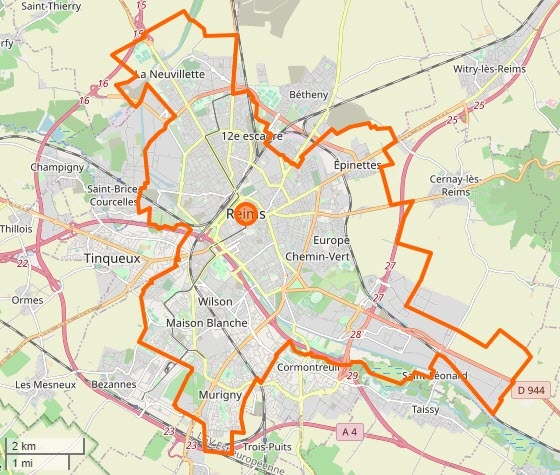

In [1]:
# Map view of Reims including the city boundaries. This is a screenshot from https://www.openstreetmap.org
from IPython.display import Image
Image(filename='Reims.jpg')

**Note:** Bétheny, Bezannes, Champigny, Cormontreuil, Les Mesneux, Ormes, Saint-Brice-Courcelles, Thillois and Tinqueux are out of Reims city boundaries. The data that are related to those towns will be discarded for the data analysis.

This project is split into the following chapters:  
* **Preparation:** Import of Python modules and collection of data from [OpenStreetMap](https://www.openstreetmap.org)
* **Data Wrangling:** Wrangling of the data
* **SQL Database Creation:** Cleaning of the OSM dataset, creation of CSV files and creation of SQL database
* **Data Analysis:** Analysis of the data and plotting of the results

<a id='preparation'></a>
## 2. Preparation
Shortcut to chapters <a href='#introduction'>1</a>, <a href='#preparation'>2</a>, <a href='#wrangling'>3</a>, <a href='#sql'>4</a>, <a href='#analysis'>5</a> and <a href='#conclusion'>6</a>.  

This chapter intends to prepare all the data for this project by:  
* Importing Python modules and determing Python version
* Downloading the OSM file
* Generating the OSM sample file
* Downloading the OSM boundary file defining the city boundaries partially
* Showing the size of the different OSM files

Let's define the following variables first.

In [2]:
FULL_FILE = "Reims.osm"
SAMPLE_FILE = "ReimsSample.osm"
BOUNDARY_FILE = "ReimsBoundaries.osm"

### 2.1. Python Modules / Version
The Python modules that are used in this project are imported.

In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import codecs
from collections import defaultdict
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pprint
import re
import requests
import sqlite3
import sys
import time
import xml.etree.ElementTree as ET #xml.etree.cElementTree as ET

In [4]:
# Shows Python version
sys.version

'3.6.0 |Anaconda 4.3.1 (64-bit)| (default, Dec 23 2016, 11:57:41) [MSC v.1900 64 bit (AMD64)]'

### 2.2. OSM File
The following steps explain how I downloaded the OSM file for Reims city. It also helps to get a image (see <a href='#introduction'>§1</a>) and the coordinates (latitude and longitude) that could be used in an automatic download.  
* Go to [OpenStreetMap](https://www.openstreetmap.org)  
* Search *Reims*  
* Select the first result *City Boundary* to display the boundaries. See the picture displayed above  
* Click on *Export* button and then on *Manually select a different area* to adjust the area to be exported (and to write down the coordinates)  

As the above standard export fails due to the high number of nodes requested, *Overpass API* is used to export the file following the next steps:  
* Go to [Overpass API](http://overpass-api.de/query_form.html)  
* Enter the following code in the *query form*: `(node(49.2187,3.9486,49.2892,4.0807);<;);out meta;`  
* Click on *Query* button  
* The *interpreter* file is downloaded. I rename it *Reims.osm*

In order to make this process automatic (using the coordinates as variables), I have retrieved the following code. Unfortunately, it does not work.

In [5]:
'''
def download_file(url, filename):
    r = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
         for chunk in r.iter_content(chunk_size=4096):
            if chunk:
                f.write(chunk)
                
url = 'http://overpass-api.de/api/map?bbox=49.2187,3.9486,49.2892,4.0807'
osm_file = 'Reims'
download_file(url, osm_file)
'''

"\ndef download_file(url, filename):\n    r = requests.get(url, stream=True)\n    with open(filename, 'wb') as f:\n         for chunk in r.iter_content(chunk_size=4096):\n            if chunk:\n                f.write(chunk)\n                \nurl = 'http://overpass-api.de/api/map?bbox=49.2187,3.9486,49.2892,4.0807'\nosm_file = 'Reims'\ndownload_file(url, osm_file)\n"

In [6]:
'''
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
(node(49.2187,3.9486,49.2892,4.0807);<;);
out meta;
"""
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
'''

'\noverpass_url = "http://overpass-api.de/api/interpreter"\noverpass_query = """\n(node(49.2187,3.9486,49.2892,4.0807);<;);\nout meta;\n"""\nresponse = requests.get(overpass_url, \n                        params={\'data\': overpass_query})\n'

### 2.3. OSM Sample File
The script below, which is provided by Udacity, generates the sample file.

In [7]:
k = 25 # Parameter: take every k-th top level element. The value was tuned to get the appropriate sample file size.

def get_element(filename, tags=('node', 'way', 'relation')):
    context = iter(ET.iterparse(filename, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()

with open(SAMPLE_FILE, 'w',encoding='utf-8') as output:
    output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write('<osm>\n  ')
    # Write every kth top level element
    for i, element in enumerate(get_element(FULL_FILE)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='utf-8').decode())
    output.write('</osm>')

### 2.4. OSM Boundary File
The script below generates the boundary file, which contains the city boundaries partially. The boundaries are defined through the relation element **"36458"** in [OpenStreetMap](https://www.openstreetmap.org). This will be used to plot Reims boundaries in chapter <a href='#analysis'>§5</a>.

In [8]:
def create_file (filename, elm, list_id):
    with open(filename, 'w',encoding='utf-8') as output:
        output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
        output.write('<osm>\n  ')
        
        for i, element in enumerate(get_element(FULL_FILE)):
            if element.tag == elm and element.attrib['id'] in list_id:
                output.write(ET.tostring(element, encoding='utf-8').decode())
        output.write('</osm>')

create_file("ReimsBoundaries.osm", "relation",["36458"])

### 2.5. Size of OSM Files
The size is calculated below.

In [9]:
print("Size of the OSM files:")
print("Full file: ", FULL_FILE, " > ", round(os.path.getsize(FULL_FILE)/1024/1000,1),"Mo")
print("Sample file:", SAMPLE_FILE, " > ", round(os.path.getsize(SAMPLE_FILE)/1024/1000,1),"Mo")
print("Boundary file:", BOUNDARY_FILE, " > ", round(os.path.getsize(BOUNDARY_FILE)/1024/1000,1),"Mo")

Size of the OSM files:
Full file:  Reims.osm  >  136.7 Mo
Sample file: ReimsSample.osm  >  5.5 Mo
Boundary file: ReimsBoundaries.osm  >  0.0 Mo


<a id='wrangling'></a>
## 3. Data Wrangling
Shortcut to chapters <a href='#introduction'>1</a>, <a href='#preparation'>2</a>, <a href='#wrangling'>3</a>, <a href='#sql'>4</a>, <a href='#analysis'>5</a> and <a href='#conclusion'>6</a>.  

This chapter intends to wrangle the data. Indeed, before creating the SQL database (<a href='#sql'>§4</a>) and exploring the data (<a href='#analysis'>§5</a>), the data set needs to be cleaned. As the data set is large, the wrangling will only focus on the data that will be analyzed. It will be done through the following steps:  
* Overview of the data
* Wrangling of the data related to the postcode and the city name
* Wrangling of the data related to the street name.
* Summary on the data wrangling

In [10]:
# The overall elapsed time will be calculated. First, the start time is calculated.
start_time = time.time()

In [11]:
'''
This code defines the OSM file to be used. Indeed:
 - First, the data wrangling has been tested on the sample file to debug the code.
 - Then, the full file is now used as the code works properly.
'''
#MY_FILE = SAMPLE_FILE
MY_FILE = FULL_FILE

### 3.1. Overview
A few statistics are calculated in order to know the data set better and maybe identify any problems in the data set. Please note that the sample file is also very useful to have a closer look to the data set.
* Count of the unique users
* Count of the different types of tag
* Count of the different types of attributes
* Count of the 4 pre-defined types of value for the attribute *k*
* Count of the different types of value for the attribute *k*
* Count of the different values of postcode

In [12]:
# Counts the number of unique users
def count_users(filename):
    users = set()
    for _, element in ET.iterparse(filename):
        if 'uid' in element.attrib.keys():
            users.add(element.attrib['uid'])
    return users

users = count_users(MY_FILE)
print("Number of unique users:",len(users))

Number of unique users: 463


In [13]:
# Counts the different types of tags
def count_tags(filename):
    tags = {}
    for event, elem in ET.iterparse(filename):
        if elem.tag in tags:
            tags[elem.tag] += 1
        else:
            tags[elem.tag] = 1
    return tags

tags = count_tags(MY_FILE)
pprint.pprint(tags)

{'member': 129771,
 'meta': 1,
 'nd': 804455,
 'node': 521617,
 'note': 1,
 'osm': 1,
 'relation': 1189,
 'tag': 367606,
 'way': 93338}


In [14]:
# Counts the different types of attributes
def count_attributes(filename):
    attributes = {}
    for event, elem in ET.iterparse(filename, events=('start', 'end')):
        if event == 'end':
            for attr in elem.attrib:
                if attr not in attributes:
                    attributes[attr] = 1
                else:
                    attributes[attr] += 1
    return attributes

attributes = count_attributes(MY_FILE)
pprint.pprint(attributes)

{'changeset': 616144,
 'generator': 1,
 'id': 616144,
 'k': 367606,
 'lat': 521617,
 'lon': 521617,
 'osm_base': 1,
 'ref': 934226,
 'role': 129771,
 'timestamp': 616144,
 'type': 129771,
 'uid': 616144,
 'user': 616144,
 'v': 367606,
 'version': 616145}


In [15]:
'''
This code processes the file in order to classify the value of the attibute 'k' for all 'tag' element tags.
It creates a dictionnary with 4 keys:
 - lower
 - lower_colon
 - problemchars
 - other
The 3 regex are also used in Udacity.
'''
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

def key_type(element, keys):
    if element.tag == "tag":       
        attribut = element.attrib['k']
        if lower.search(attribut):
            keys["lower"] += 1
        elif problemchars.search(attribut):
            keys["problemchars"] += 1
        elif lower_colon.search(attribut):
            keys["lower_colon"] += 1
        else:
            keys["other"] += 1     
    return keys

def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)
    return keys

keys = process_map(MY_FILE)
pprint.pprint(keys)

{'lower': 274913, 'lower_colon': 89214, 'other': 3479, 'problemchars': 0}


**Note:** No value is identified with problematic characters. It shows a good quality of the original dataset.

In [16]:
# Counts the different types of value for the attribute *k*
lower = re.compile(r'^([a-z]|_)*$')

def audit_tag(filename):
    tag_types = {}
    for event, elem in ET.iterparse(filename, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                key = tag.attrib['k']
                if lower.search(key):
                    if key in tag_types.keys():
                        tag_types[key] += 1
                    else:
                        tag_types[key] = 1
    return tag_types

tag_types = audit_tag(MY_FILE)
print("Number of occurrences:", sum(tag_types.values()))
print("Number of occurrences per tag (top 50):")
sorted_dict = [(k, v) for (v, k) in sorted([(value, key) for (key, value) in tag_types.items()], reverse=True)]
pprint.pprint(sorted_dict[0:50])

Number of occurrences: 265369
Number of occurrences per tag (top 50):
[('source', 81815),
 ('building', 68265),
 ('highway', 17328),
 ('wall', 14421),
 ('name', 11652),
 ('amenity', 7701),
 ('natural', 3514),
 ('oneway', 3016),
 ('operator', 2712),
 ('maxspeed', 2203),
 ('service', 2060),
 ('landuse', 2003),
 ('barrier', 1849),
 ('crossing', 1824),
 ('surface', 1774),
 ('access', 1700),
 ('ref', 1653),
 ('leisure', 1615),
 ('place', 1507),
 ('denotation', 1445),
 ('phone', 1368),
 ('start_date', 1311),
 ('public_transport', 1180),
 ('bus', 1165),
 ('network', 1076),
 ('emergency', 932),
 ('shop', 928),
 ('direction', 924),
 ('entrance', 886),
 ('railway', 878),
 ('website', 819),
 ('shelter', 756),
 ('layer', 749),
 ('leaf_type', 737),
 ('capacity', 732),
 ('opening_hours', 709),
 ('water_source', 682),
 ('departures_board', 660),
 ('crossing_ref', 649),
 ('power', 627),
 ('bicycle_parking', 597),
 ('office', 595),
 ('lanes', 574),
 ('bench', 566),
 ('description', 530),
 ('wikidata', 

**Note:** The list of values is large. Based on the above values, the following data will be analyzed in chapter <a href='#analysis'>§5</a>:
* Source
* Amenity
* Leisure
* Shop

In [17]:
# Counts the different values of postcode
def count_postcodes(filename):
    postcodes = {}
    for event, elem in ET.iterparse(filename, events=('start', 'end')):
        if event == 'end':
            key = elem.attrib.get('k')
            if key == 'addr:postcode':
                postcode = elem.attrib.get('v')
                if postcode not in postcodes:
                    postcodes[postcode] = 1
                else:
                    postcodes[postcode] += 1
    return postcodes

postcodes = count_postcodes(MY_FILE)
print("Number of occurrences:", sum(postcodes.values()))
print("Number of occurrences per postcode:")
sorted_dict = [(k, v) for (v, k) in sorted([(value, key) for (key, value) in postcodes.items()], reverse=True)]
pprint.pprint(sorted_dict)

Number of occurrences: 2971
Number of occurrences per postcode:
[('51100', 1954),
 ('51430', 434),
 ('51370', 302),
 ('51450', 188),
 ('51350', 78),
 ('51109', 7),
 ('51688', 3),
 ('51092', 2),
 ('51721', 1),
 ('51687', 1),
 ('51 100', 1)]


**Note:** The list of postcodes is quite small. It makes sense as the OSM file was exported on a small area. We can notice that:
* The top value is *51100*, which is Reims postcode
* Other values are the postcodes for the neighbouring towns
* Other values are not the standard postcodes

**Summary:**  
A few data have been quickly analyzed above. It provides a quick overview of the file content and the data wrangling to be performed. The data wrangling will deal with the following data:
* The postcode and the city name (based on the above observations)
* The street name (by experience, the street names need to be corrected)

### 3.2. Data: Postcode & City Name
The dataset is analyzed in order to extract the different values for:  
* All the *city* names
* All the *postcodes*
* All the associations *postcode/city name*

In [18]:
'''
The function audit_city is used to parse the OSM file in order to create 3 dictionaries:
- Dictionary cities: key = city name and value = number of occurrences
- Dictionary postcodes: key = postcode and value = number of occurrences
- Dictionary postcodes2: key = postcode and value = any associated city name
'''

# Returns a boolean: True if the value of the 'k' attribute is a postcode
def is_postcode(elem):
    return (elem.attrib['k'] == "addr:postcode")

# Returns a boolean: True if the value of the 'k' attribute is a city name
def is_city(elem):
    return (elem.attrib['k'] == "addr:city")
 
def audit_city(filename):
    cities = {}
    postcodes = {}
    postcodes2 = defaultdict(set)
    for event, elem in ET.iterparse(filename, events=("start",)):
        if elem.tag in ['node', 'way', 'relation']:
            city = ""
            postcode = ""
            for tag in elem.iter("tag"):
                if is_city(tag):
                    city = tag.attrib['v']
                    if city in cities.keys():
                        cities[city] += 1
                    else:
                        cities[city] = 1
                if is_postcode(tag):
                    postcode = tag.attrib['v']
                    if postcode in postcodes.keys():
                        postcodes[postcode] += 1
                    else:
                        postcodes[postcode] = 1
                postcodes2[postcode].add(city)
    return cities, postcodes, postcodes2

cities, postcodes, postcodes2 = audit_city(MY_FILE)

In [19]:
# Prints the 1st result cities with the number of occurrences sorted in descending order
print("Number of occurrences:", sum(cities.values()))
print("Number of occurrences per city:")
sorted_cities = [(k, v) for (v, k) in sorted([(value, key) for (key, value) in cities.items()], reverse=True)]
pprint.pprint(sorted_cities)

Number of occurrences: 2407
Number of occurrences per city:
[('Reims', 1419),
 ('Tinqueux', 382),
 ('Saint-Brice-Courcelles', 189),
 ('Bétheny', 164),
 ('Bezannes', 77),
 ('Cormontreuil', 71),
 ('Thillois', 50),
 ('Champigny', 24),
 ('Ormes', 20),
 ('Les Mesneux', 5),
 ('BEZANNES', 3),
 ('Saint-Brice-Courcelles03 26 04 51 43', 1),
 ('REIMS Cedex', 1),
 ('Bezanne', 1)]


**Note:** The number of occurrences per city is not surprising. It can be noticed that the below city names are incorrect. Therefore, the dictionary **mapping_city** is created for the cleaning. 
* *BEZANNES* and *Bezanne* to be replaced by *Bezannes*)
* *REIMS Cedex* to be replaced by *Reims*
* *Saint-Brice-Courcelles03 26 04 51 43* to be replaced by *Saint-Brice-Courcelles*

In [20]:
mapping_city = {"BEZANNES": "Bezannes",
                "Bezanne": "Bezannes",
                "REIMS Cedex": "Reims",
                "Saint-Brice-Courcelles03 26 04 51 43": "Saint-Brice-Courcelles"
               }

In [21]:
# Prints the 2nd result postcodes with the number of occurrences sorted in descending order
print("Number of occurrences:", sum(postcodes.values()))
print("Number of occurrences per postcode:")
sorted_postcodes = [(k, v) for (v, k) in sorted([(value, key) for (key, value) in postcodes.items()], reverse=True)]
pprint.pprint(sorted_postcodes)

Number of occurrences: 2937
Number of occurrences per postcode:
[('51100', 1930),
 ('51430', 430),
 ('51370', 299),
 ('51450', 186),
 ('51350', 78),
 ('51109', 6),
 ('51688', 3),
 ('51092', 2),
 ('51721', 1),
 ('51687', 1),
 ('51 100', 1)]


**Note:** The 5 most frequent postcodes above are related to the following cities:
* *51100*: Reims
* *51350*: Cormontreuil
* *51370*: Champigny, Les Mesneux, Ormes, Saint-Brice-Courcelles, Thillois
* *51430*: Bezannes, Tinqueux
* *51450*: Bétheny  

Therefore, no correction is required.  
However, the remaining postcodes should be corrected for the following reasons and the dictionary **mapping_postcode** is created for the cleaning.
* *51109*: Insee code. Let's set this value blank.
* *51092*, *51687*, *51688* and *51721* are CEDEX postcodes. CEDEX stands for Courrier d'Entreprise à Distribution EXceptionnel. It is a service offered by La Poste to businesses allowing them to have their post given priority. Normally the 5 digit code always comes with the keyword CEDEX. However, these CEDEX postcodes can be associated to a city: *51092*, *51687* and *51688* are CEDEX postcodes for Reims and *51721* for Bétheny.
* *51 100* is a typo error and should be replaced by *51100*

In [22]:
mapping_postcode = {"51109": "",
                    "51092": "51100",
                    "51687": "51100",
                    "51688": "51100",
                    "51721": "51450",
                    "51 100": "51100",
                   }

In [23]:
print("Association postcode vs city:")
pprint.pprint(postcodes2)

Association postcode vs city:
defaultdict(<class 'set'>,
            {'': {'',
                  'BEZANNES',
                  'Bezanne',
                  'Bezannes',
                  'Bétheny',
                  'Champigny',
                  'Cormontreuil',
                  'Les Mesneux',
                  'Ormes',
                  'REIMS Cedex',
                  'Reims',
                  'Saint-Brice-Courcelles',
                  'Saint-Brice-Courcelles03 26 04 51 43',
                  'Thillois',
                  'Tinqueux'},
             '51 100': {''},
             '51092': {'Reims'},
             '51100': {'', 'Reims', 'Tinqueux'},
             '51109': {''},
             '51350': {'', 'Cormontreuil'},
             '51370': {'',
                       'Champigny',
                       'Les Mesneux',
                       'Ormes',
                       'Saint-Brice-Courcelles',
                       'Saint-Brice-Courcelles03 26 04 51 43',
                       'Thi

**Note:** The above result only shows that *Tinqueux* has different postcodes (*51100*, *51370* and *51430*), which is incorrect. The correct one is *51430*. But a deeper investigation should be done to check the full address to determine whether the city name or the postcode is incorrect. In order to make this analysis easier, we will assume that the postcode is always correct in case of inconsistency between the city name and the postcode.

**Summary:**  

First, let's highlight a few points:
* The postcodes and cities are quite well filled out.
* The postcodes are more frequently provided than the city names.
* A few postcodes correspond to several cities e.g. 51370 for Champigny, Les Mesneux, Ormes, Saint-Brice-Courcelles and Thillois. So, no udpate is required.

Then, when the database will be created, the incorrect values for postcodes and city names will be corrected using the two dictionaries **mapping_city** and **mapping_postcode**.

### 3.3. Data: Street Name
The street name will not be analyzed in this project. However, this will allow us to have a cleaned dataset for the street names in case of further analysis. It is also a good exercise from my point of view. 

In [24]:
'''
The function audit_street is used to parse the OSM file in order to create the dictionary street_types containing 
all street names that are not expected (see list expected)
'''

# Regex modified to be used for French street names
street_type_re = re.compile(r'^\b\S+\.?', re.IGNORECASE)

# List of expected street types
expected = ["Allée", "Avenue", "Boulevard", "Campus", "Chaussée", "Chemin", "Cour", "Cours", "Esplanade",
            "Galerie", "Impasse", "Parc", "Passage", "Place", "Promenade", "Quai", "Rond-Point", "Route",
            "Rue" , "Ruelle", "Voie"]

# Adds the street_name to the dictionary street_types if the street_name is not expected
def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)

# Returns a boolean: True if the value of the 'k' attribute is a street name
def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

def audit_street(filename):
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(filename, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    return street_types

street_types = audit_street(MY_FILE)
pprint.pprint(dict(street_types))

{'2': {'2 Rue Saint-Charles'},
 'Grande': {'Grande Rue'},
 'Groupe': {'Groupe Dijon'},
 'avenue': {'avenue Georges Clemenceau'},
 'bis': {'bis rue gabriel voisin'},
 'impasse': {"impasse du val d'or"},
 'route': {'route de soissons'},
 'rue': {'rue Gabriel Voisin',
         'rue Léon Patoux',
         'rue de Neufchâtel',
         'rue de la Ferme Pierquin',
         'rue des acacias'},
 'vernouillet': {'vernouillet'}}


**Note:** The dictionary **expected** has been updated iteratively. With the latest version, only a few street names are identified above. Most of updates will consist in changing the first lowercase letter by an uppercase letter and also removing *bis* (usually used along with the street number) and adding *Rue* to the street name *Vernouillet*. Therefore, the dictionary **mapping_street** is created for the cleaning.

In [25]:
mapping_street = {"rue": "Rue",
                  "bis rue": "Rue",
                  "impasse": "Impasse",
                  "route": "Route",
                  "avenue": "Avenue",
                  "vernouillet": "Rue Vernouillet"
                 }

**Summary:** The dataset is already clean in terms of street names. Indeed, the above corrections are minor.

### 3.4. Summary
It can be highlighted that the original OSM file already had clean and consistent data. However, some corrections will be required in order to make the dataset even cleaner. The above dictionaries **mapping_city**, **mapping_postcode** and **mapping_street** will be used in the next chapter.

Many other cleaning could have been done on other fields such as the phone number. But the above cleaning is enough to have consistent data for the data analysis in chapter <a href='#analysis'>§5</a>

<a id='sql'></a>
## 4. SQL Database Creation
Shortcut to chapters <a href='#introduction'>1</a>, <a href='#preparation'>2</a>, <a href='#wrangling'>3</a>, <a href='#sql'>4</a>, <a href='#analysis'>5</a> and <a href='#conclusion'>6</a>.  

The SQL database will be created into 3 steps:
* Creation of the CSV files along with the cleaning of the dataset 
* Creation of the SQL database **Reims.db** along with the tables
* Insertion of the CSV files into the tables

**Note:** As the below code is mainly retrieved from Udacity Module "Data Wrangling With MongoDB", the code will not be explained thoroughly.

### 4.1. Creation of the CSV files
The CSV files are created using the following code.

In [26]:
# Name of the CSV files
NODES_PATH = "nodes.csv"
NODES_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAYS_NODES_PATH = "ways_nodes.csv"
WAYS_TAGS_PATH = "ways_tags.csv"

# Regex used in the below code
LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

# Fields used in the below code (in accordance with the future tables created in the SQL database)
NODES_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODES_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAYS_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAYS_NODES_FIELDS = ['id', 'node_id', 'position']
WAYS_TAGS_FIELDS = ['id', 'key', 'value', 'type']

# Updates every part of the streetname, if required, by using the values provided in the dictionary mapping
def update_streetname(value, mapping):
    after = []
    for part in value.split(" "):
        if part in mapping.keys():
            part = mapping[part]
        after.append(part)
    better_name = " ".join(after)
    return better_name

# Updates the complete value using the values provided in the dictionaries defined above mapping_city and mapping_postcode
def update_value(value, key):
    if value in mapping_city.keys():
        return mapping_city[value]
    elif value in mapping_postcode.keys():
        return mapping_postcode[value]
    elif key == "addr:street":
        return update_streetname(value,mapping_street)
    else:
        return value

# Function retrieved from Udacity and slightly modified to correct the values of each field
def shape_element(element, node_attr_fields=NODES_FIELDS, way_attr_fields=WAYS_FIELDS,
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):
    """Clean and shape node or way XML element to Python dict"""

    nodes_attribs = {}
    ways_attribs = {}
    ways_nodes = []
    tags = []  # Handle secondary tags the same way for both node and way elements

    if element.tag == 'node':
        for item in element.attrib.keys():
            if item in NODES_FIELDS:
                nodes_attribs[item] = element.attrib[item]
        
        field = {}
        for tag in element.iter("tag"):
            p = PROBLEMCHARS.search(tag.attrib['k'])
            l = LOWER_COLON.search(tag.attrib['k'])
            if p:
                continue
            elif l:
                field = {
                        'id':  element.attrib['id'],
                        'key': ":".join(tag.attrib['k'].split(":")[1:]),
                        'value': update_value(tag.attrib['v'],tag.attrib['k']),
                        'type': tag.attrib['k'].split(":")[0]
                        }
            else:
                field = {
                        'id':  element.attrib['id'],
                        'key': tag.attrib['k'],
                        'value': update_value(tag.attrib['v'],tag.attrib['k']),
                        'type': 'regular'
                        }
            tags.append(field)
            
        return {'nodes': nodes_attribs, 'nodes_tags': tags}


    elif element.tag == 'way':
        for item in element.attrib.keys():
            if item in WAYS_FIELDS:
                ways_attribs[item] = element.attrib[item]
                
        field = {}
        for tag in element.iter('tag'):
            p = PROBLEMCHARS.search(tag.attrib['k'])
            l = LOWER_COLON.search(tag.attrib['k'])
            if p:
                continue
            elif l:
                field = {
                        'id':  element.attrib['id'],
                        'key': ":".join(tag.attrib['k'].split(":")[1:]),
                        'value': update_value(tag.attrib['v'],tag.attrib['k']),
                        'type': tag.attrib['k'].split(":")[0]
                        }                   
            else:
                field = {
                        'id':  element.attrib['id'],
                        'key': tag.attrib['k'],
                        'value': update_value(tag.attrib['v'],tag.attrib['k']),
                        'type': 'regular'
                        }
            tags.append(field)
        
        field = {}
        for index, tag in enumerate(element.iter("nd")):
            field = {
                    'id':  element.attrib['id'],
                    'node_id': tag.attrib['ref'],
                    'position': index
                    }
            ways_nodes.append(field)    
            
        return {'ways': ways_attribs, 'ways_nodes': ways_nodes, 'ways_tags': tags}

# Function retrieved from Udacity 
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""
    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()

# Function retrieved from Udacity.
def process_map(file_in):
    """Iteratively process each XML element and write to csv(s)"""

    with codecs.open(NODES_PATH, 'w', encoding="utf-8") as nodes_file, \
        codecs.open(NODES_TAGS_PATH, 'w',encoding="utf-8") as nodes_tags_file, \
        codecs.open(WAYS_PATH, 'w', encoding="utf-8") as ways_file, \
        codecs.open(WAYS_NODES_PATH, 'w', encoding="utf-8") as ways_nodes_file, \
        codecs.open(WAYS_TAGS_PATH, 'w', encoding="utf-8") as ways_tags_file:

        nodes_writer = csv.DictWriter(nodes_file, NODES_FIELDS)
        nodes_tags_writer = csv.DictWriter(nodes_tags_file, NODES_TAGS_FIELDS)
        ways_writer = csv.DictWriter(ways_file, WAYS_FIELDS)
        ways_nodes_writer = csv.DictWriter(ways_nodes_file, WAYS_NODES_FIELDS)
        ways_tags_writer = csv.DictWriter(ways_tags_file, WAYS_TAGS_FIELDS)

        nodes_writer.writeheader()
        nodes_tags_writer.writeheader()
        ways_writer.writeheader()
        ways_nodes_writer.writeheader()
        ways_tags_writer.writeheader()
        
        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if element.tag == 'node':
                    nodes_writer.writerow(el['nodes'])
                    nodes_tags_writer.writerows(el['nodes_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['ways'])
                    ways_nodes_writer.writerows(el['ways_nodes'])
                    ways_tags_writer.writerows(el['ways_tags'])

process_map(MY_FILE)

**Note:** The 5 CSV files are now created but as we want to focus on the data in *Reims* city, the CSV files containing the tags will be updated in order to remove all postcodes not equal to *51100*. No update is done on the city names to make this analysis quicker. But as seen above, a few tags concern cities without any postcode, so some tags might concern the neighbouring towns.

In [27]:
'''
The function drop_df_rows removes the rows of the CSV file containing data in the neighbouring cities.
This is done in 2 steps:
- First, any id with an associated postcode not equal to '51100' is added to a list
- Second, all the rows whose id is in that list are removed
Indeed, the idea is not to remove only the row with the other postcode but to remove all the data related to the 
other postcodes.
The number of rows removed is printed as well.
'''
def drop_df_rows(filename):
    df = pd.read_csv(filename, encoding = 'utf-8')
    before = len(df)
    df_list = df[(df.type == 'addr') & (df.key == 'postcode') & (df.value != '51100')]
    ids = []
    ids = df_list['id'].tolist()
    df = df.query("id not in @ids")
    #df = df[df['id'] in ids]
    after = len(df)
    print("{} rows removed in {} file.".format((before - after), filename))
    df.to_csv(filename, index = False, encoding = 'utf-8')

drop_df_rows('nodes_tags.csv')
drop_df_rows('ways_tags.csv')

5239 rows removed in nodes_tags.csv file.
620 rows removed in ways_tags.csv file.


**Note:** In order to extract the city boundaries from the OSM boundary file, which will be used in the data analysis, a similar code is used.

In [28]:
RELATIONS_MEMBERS_PATH = "relations_members.csv"
RELATIONS_MEMBERS_FIELDS = ['id', 'ref', 'role', 'type']

with codecs.open(RELATIONS_MEMBERS_PATH, 'w', encoding="utf-8") as relations_members_file:
    relations_members_writer = csv.DictWriter(relations_members_file, RELATIONS_MEMBERS_FIELDS)
    relations_members_writer.writeheader()
    for element in get_element(BOUNDARY_FILE, tags=('relation',)):
        tags = []
        field = {}
        for tag in element.iter('member'):
            field = {
                    'id':  element.attrib['id'],
                    'ref': tag.attrib['ref'],
                    'role': tag.attrib['role'],
                    'type': tag.attrib['type']
                    }
            tags.append(field)
        relations_members_writer.writerows(tags)

**Note:** The CSV file is now created.

### 4.2. Creation of the SQL Database and the Tables
The database **Reims.db** along with the tables are created below.

In [29]:
conn = sqlite3.connect("Reims.db")

c = conn.cursor()

c.execute('''DROP TABLE IF EXISTS nodes''')
c.execute('''DROP TABLE IF EXISTS nodes_tags''')
c.execute('''DROP TABLE IF EXISTS ways''')
c.execute('''DROP TABLE IF EXISTS ways_tags''')
c.execute('''DROP TABLE IF EXISTS ways_nodes''')
c.execute('''DROP TABLE IF EXISTS relations_members''')

conn.commit()

QUERY_NODES = """
CREATE TABLE nodes (
    id INTEGER NOT NULL,
    lat REAL,
    lon REAL,
    user TEXT,
    uid INTEGER,
    version INTEGER,
    changeset INTEGER,
    timestamp TEXT
);
"""

QUERY_NODES_TAGS = """
CREATE TABLE nodes_tags (
    id INTEGER,
    key TEXT,
    value TEXT,
    type TEXT,
    FOREIGN KEY (id) REFERENCES node(id)
);
"""

QUERY_WAYS = """
CREATE TABLE ways (
    id INTEGER NOT NULL,
    user TEXT,
    uid INTEGER,
    version INTEGER,
    changeset INTEGER,
    timestamp TEXT
);
"""

QUERY_WAYS_TAGS = """
CREATE TABLE ways_tags (
    id INTEGER NOT NULL,
    key TEXT NOT NULL,
    value TEXT NOT NULL,
    type TEXT,
    FOREIGN KEY (id) REFERENCES way(id)
);
"""

QUERY_WAYS_NODES = """
CREATE TABLE ways_nodes (
    id INTEGER NOT NULL,
    node_id INTEGER NOT NULL,
    position INTEGER NOT NULL,
    FOREIGN KEY (id) REFERENCES way(id),
    FOREIGN KEY (node_id) REFERENCES node(id)
);
"""

QUERY_RELATIONS_MEMBERS = """
CREATE TABLE relations_members (
    id INTEGER NOT NULL,
    ref TEXT NOT NULL,
    role TEXT NOT NULL,
    type TEXT
);
"""

c.execute(QUERY_NODES)
c.execute(QUERY_NODES_TAGS)
c.execute(QUERY_WAYS)
c.execute(QUERY_WAYS_TAGS)
c.execute(QUERY_WAYS_NODES)
c.execute(QUERY_RELATIONS_MEMBERS)

conn.commit()

### 4.3. Insertion of Data into Database Tables
The data contained in the CSV files are inserted into the database tables.

In [30]:
with open('nodes.csv','r', encoding='utf-8') as f:
    dr = csv.DictReader(f) # comma is default delimiter
    to_db1 = [(i['id'], i['lat'], i['lon'], i['user'], i['uid'], i['version'], i['changeset'], i['timestamp']) for i in dr]
    
with open('nodes_tags.csv','r',encoding='utf-8') as f:
    dr = csv.DictReader(f) # comma is default delimiter
    to_db2 = [(i['id'], i['key'], i['value'], i['type']) for i in dr]
    
with open('ways.csv','r', encoding='utf-8') as f:
    dr = csv.DictReader(f) # comma is default delimiter
    to_db3 = [(i['id'], i['user'], i['uid'], i['version'], i['changeset'], i['timestamp']) for i in dr]
    
with open('ways_tags.csv','r', encoding='utf-8') as f:
    dr = csv.DictReader(f) # comma is default delimiter
    to_db4 = [(i['id'], i['key'], i['value'], i['type']) for i in dr]
    
with open('ways_nodes.csv','r', encoding='utf-8') as f:
    dr = csv.DictReader(f) # comma is default delimiter
    to_db5 = [(i['id'], i['node_id'], i['position']) for i in dr]

with open('relations_members.csv','r', encoding='utf-8') as f:
    dr = csv.DictReader(f) # comma is default delimiter
    to_db6 = [(i['id'], i['ref'], i['role'], i['type']) for i in dr]

In [31]:
# Inserts the data into the database tables
c.executemany("INSERT INTO nodes(id, lat, lon, user, uid, version, changeset, timestamp) VALUES (?, ?, ?, ?, ?, ?, ?, ?);", to_db1)
c.executemany("INSERT INTO nodes_tags(id, key, value, type) VALUES (?, ?, ?, ?);", to_db2)
c.executemany("INSERT INTO ways(id, user, uid, version, changeset, timestamp) VALUES (?, ?, ?, ?, ?, ?);", to_db3)
c.executemany("INSERT INTO ways_tags(id, key, value, type) VALUES (?, ?, ?, ?);", to_db4)
c.executemany("INSERT INTO ways_nodes(id, node_id, position) VALUES (?, ?, ?);", to_db5)
c.executemany("INSERT INTO relations_members(id, ref, role, type) VALUES (?, ?, ?, ?);", to_db6)

conn.commit()

**Summary:** The SQL database **Reims.db** is now created. The data analysis can now be done by making some queries.

<a id='analysis'></a>
## 5. Data Analysis
Shortcut to chapters <a href='#introduction'>1</a>, <a href='#preparation'>2</a>, <a href='#wrangling'>3</a>, <a href='#sql'>4</a>, <a href='#analysis'>5</a> and <a href='#conclusion'>6</a>.

The data analysis will focus on several aspects:
* The contributors and the source data
* The leisure and the amenities
* The restaurants, cafés and bars
* The shops  

We will plot the location of the restaurants, the cafés, the bars and the shops in order to identify good places to live in Reims. We could have done the same for other facilities such as the schools.

### 5.1. OpenStreetMap Contributors and Source Data

In [32]:
# Counts the number of nodes and ways
c.execute('SELECT COUNT(*) FROM nodes')
results = c.fetchall()
print('Number of nodes in the database:', results[0][0])

c.execute('SELECT COUNT(*) FROM ways')
results = c.fetchall()
print('Number of ways in the database:',results[0][0])

Number of nodes in the database: 521617
Number of ways in the database: 93338


In [33]:
# Shows the top 10 contributors (i.e. the users with the highest number of contributions)
QUERY = '''
SELECT DISTINCT user, COUNT(*)
FROM (SELECT id, user, uid FROM nodes UNION ALL SELECT id, user, uid FROM ways) element
GROUP BY user
ORDER BY COUNT(*) DESC
LIMIT 10;
'''
c.execute(QUERY)
results = c.fetchall()
print("Top 10 contributors:")
pprint.pprint(results)

Top 10 contributors:
[('MXS', 181226),
 ('MM51', 120721),
 ('Ours51', 87495),
 ('Denis_Helfer', 66151),
 ('Reims Moderne', 46160),
 ('botdidier2020', 26082),
 ('Super-Map', 14509),
 ('AmiFritz', 10762),
 ('Hugo-D', 8343),
 ('meihou', 4703)]


In [34]:
# Shows the top 10 source data
QUERY = '''
SELECT value, COUNT(*)
FROM (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) tags
WHERE key = 'source'
GROUP BY value
ORDER BY COUNT(*) DESC
LIMIT 10;
'''
c.execute(QUERY)
results = c.fetchall()
print("Top 10 source data:")
for row in results:
    print(row[0], ',', row[1])

Top 10 source data:
cadastre-dgi-fr source : Direction Générale des Impôts - Cadas. Mise à jour : 2010 , 51055
extraction vectorielle v1 cadastre-dgi-fr source : Direction Générale des Impôts - Cadas. Mise à jour : 2010 , 8913
Direction Générale des Finances Publiques - cadastre. Mise à jour : 2016 , 6954
cadastre-dgi-fr source : Direction Générale des Impôts - Cadastre. Mise à jour : 2011 , 2845
Direction Générale des Finances Publiques - cadastre. Mise à jour : 2015 , 2748
cadastre-dgi-fr source : Direction Générale des Impôts - Cadastre. Mise à jour : 2012 , 1686
cadastre-dgi-fr source : Direction Générale des Impôts - Cadastre;mise à jour : 2008 , 1060
Bing , 1052
cadastre-dgi-fr source : Direction Générale des Impôts - Cadastre ; mise à jour : 2008 , 1048
cadastre-dgi-fr source : Direction Générale des Impôts - Cadastre. Mise à jour : 2016 , 855


### 5.2. Leisure and Amenities in Reims

In [35]:
# Counts the top 10 leisure
QUERY = '''
SELECT value, COUNT(*) as Count
FROM (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) tags
WHERE key = 'leisure'
GROUP BY value
ORDER BY Count DESC
LIMIT 10;
'''
c.execute(QUERY)
results = c.fetchall()
print("Top 10 leisure:")
pprint.pprint(results)

Top 10 leisure:
[('garden', 483),
 ('pitch', 390),
 ('swimming_pool', 222),
 ('park', 149),
 ('playground', 125),
 ('schoolyard', 120),
 ('sports_centre', 47),
 ('picnic_table', 32),
 ('dog_park', 23),
 ('track', 17)]


In [36]:
# Counts the top 20 amenities
QUERY = '''
SELECT value, COUNT(*) as Count
FROM (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) tags
WHERE key = 'amenity'
GROUP BY value
ORDER BY Count DESC
LIMIT 20;
'''
c.execute(QUERY)
results = c.fetchall()
print("Top 20 amenities:")
pprint.pprint(results)

Top 20 amenities:
[('parking_space', 2868),
 ('parking', 1074),
 ('bicycle_parking', 626),
 ('parking_entrance', 418),
 ('bench', 407),
 ('shelter', 245),
 ('recycling', 219),
 ('restaurant', 212),
 ('school', 175),
 ('waste_basket', 136),
 ('waste_disposal', 116),
 ('dentist', 111),
 ('post_box', 79),
 ('kindergarten', 73),
 ('pharmacy', 70),
 ('vending_machine', 58),
 ('bank', 54),
 ('place_of_worship', 52),
 ('fast_food', 49),
 ('bar', 40)]


### 5.3. Restaurants, Cafes and Bars in Reims

The below code allows us to retrieve the coordinates of the restaurants, cafés and bars in order to plot them against the city boundaries and against a image of Reims city centre.

In [37]:
QUERY = '''
SELECT nodes.lat, nodes.lon
FROM nodes, (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) tags
WHERE nodes.id = tags.id
AND tags.key = 'amenity'
AND tags.value = 'restaurant';
'''
c.execute(QUERY)
results = c.fetchall()
df = pd.DataFrame(results,columns=['lat','lon'])
ax = df.plot(kind='scatter',x='lon',y='lat', label = 'restaurant', color='blue')

In [38]:
QUERY = '''
SELECT nodes.lat, nodes.lon
FROM nodes, (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) tags
WHERE nodes.id = tags.id
AND tags.key = 'amenity'
AND (tags.value = 'bar' OR tags.value = 'cafe');
'''
c.execute(QUERY)
results = c.fetchall()
df = pd.DataFrame(results,columns=['lat','lon'])
df.plot(kind='scatter',x='lon',y='lat', label = 'bar / cafe', color='red', ax = ax)

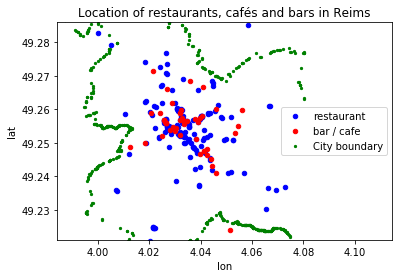

In [39]:
# Plots the city boundaries.
# The condition way_tags.key = 'boundary' has not been used. Too many points! Hence the use of relations_members
QUERY = '''
SELECT nodes.lat, nodes.lon
FROM nodes, ways_nodes, relations_members
WHERE nodes.id = ways_nodes.node_id
AND ways_nodes.id = relations_members.ref
AND relations_members.type = 'way'
AND relations_members.role = 'outer';
'''
c.execute(QUERY)
results = c.fetchall()
df = pd.DataFrame(results,columns=['lat','lon'])
df.plot(kind='scatter',x='lon',y='lat',
        title='Location of restaurants, cafés and bars in Reims',
        label = 'City boundary', color='green', marker = '.', ax = ax)
ax.set_xlim(3.9841,4.1144)
ax.set_ylim(49.2211,49.2859)
plt.show()

**Note:**  
* Some restaurant, cafes and bars are located outside the city boundaries. It might mean the dataset has not been cleaned deep enough. For instance, we could have removed the data related to the city names not being Reims.
* As the city boundaries are partially plotted, the location of the restaurant will be plotted against an image.

In [40]:
QUERY = '''
SELECT nodes.lat, nodes.lon
FROM nodes, (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) tags
WHERE nodes.id = tags.id
AND tags.key = 'amenity'
AND tags.value = 'restaurant';
'''
c.execute(QUERY)
results = c.fetchall()
df = pd.DataFrame(results,columns=['lat','lon'])

In [41]:
# The values for the latitude and longitude are modified to be plotted against the picture.
# The coordinate are not the latitude and longitude anymore.
df['lat'] = df['lat'].apply(lambda x: (x - 49.2859) * 580 / (49.2211 - 49.2859))
df['lon'] = df['lon'].apply(lambda x: (x - 3.9841) * 759 / (4.1144 - 3.9841))
df = df[(df.lat >= 0) & (df.lat <= 580)]
df = df[(df.lon >= 0) & (df.lon <= 759)]

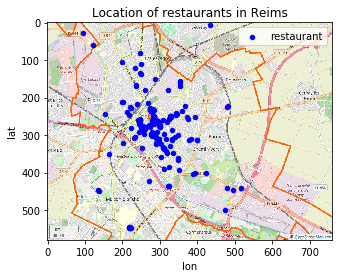

In [42]:
img = plt.imread("ReimsZoom.jpg")
fig, ax = plt.subplots()
ax.imshow(img)
df.plot(kind='scatter',x='lon',y='lat', title = 'Location of restaurants in Reims', label = 'restaurant', color='blue', ax = ax)
plt.show()

Now, let's have a look at the types of cuisine in these restaurants and also at the different fast food chains.

In [43]:
# Counts the top 10 types of cuisine
QUERY = '''
SELECT value, COUNT(*) as count
FROM (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) tags
WHERE key = 'cuisine'
GROUP BY value
ORDER BY count DESC
LIMIT 10;
'''
c.execute(QUERY)
results = c.fetchall()
print("Top 10 types of cuisine:")
pprint.pprint(results)

Top 10 types of cuisine:
[('french', 22),
 ('burger', 17),
 ('pizza', 14),
 ('italian', 9),
 ('brasserie', 6),
 ('asian', 5),
 ('chinese', 5),
 ('kebab', 4),
 ('mexican', 4),
 ('japanese', 3)]


In [44]:
# Counts the brands of fast food restaurants
QUERY = '''
SELECT value, COUNT(*) as count
FROM (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) tags
JOIN (SELECT DISTINCT(id) FROM (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) tags WHERE value = 'fast_food') as sub
ON tags.id = sub.id
WHERE key = 'brand'
GROUP BY value
ORDER BY Count DESC;
'''
c.execute(QUERY)
results = c.fetchall()
print("Top brands of fast food restaurants:")
pprint.pprint(results)

Top brands of fast food restaurants:
[("McDonald's", 6),
 ('Burger King', 2),
 ('Quick', 2),
 ('231 East Street', 1),
 ('Bagelstein', 1),
 ("Domino's", 1),
 ("Domino's Pizza", 1),
 ('KFC', 1),
 ("O'Tacos", 1),
 ('Pita Pit', 1),
 ('Subway', 1)]


### 5.4. Shops in Reims

In [45]:
# Counts the top 20 shops
QUERY = '''
SELECT value, COUNT(*) as Count
FROM (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) tags
WHERE key = 'shop'
GROUP BY value
ORDER BY Count DESC
LIMIT 20;
'''
c.execute(QUERY)
results = c.fetchall()
pprint.pprint(results)

[('clothes', 93),
 ('hairdresser', 81),
 ('bakery', 80),
 ('supermarket', 47),
 ('beauty', 40),
 ('convenience', 34),
 ('car_repair', 28),
 ('butcher', 21),
 ('florist', 20),
 ('jewelry', 20),
 ('optician', 18),
 ('alcohol', 17),
 ('car', 15),
 ('shoes', 13),
 ('tobacco', 13),
 ('yes', 13),
 ('interior_decoration', 10),
 ('laundry', 10),
 ('cosmetics', 9),
 ('furniture', 9)]


In [46]:
# Counts the different brands of supermarkets 
QUERY = '''
SELECT value, COUNT(*) as count
FROM (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) tags
JOIN (SELECT DISTINCT(id) FROM (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) tags WHERE value = 'supermarket') as sub
ON tags.id = sub.id
WHERE key = 'brand'
GROUP BY value
ORDER BY Count DESC;
'''
c.execute(QUERY)
results = c.fetchall()
print("Top brand of supermarkets:")
pprint.pprint(results)

Top brand of supermarkets:
[('Carrefour Market', 6),
 ('Lidl', 5),
 ('Carrefour City', 4),
 ('E. Leclerc Drive', 3),
 ('Carrefour', 2),
 ('G20', 2),
 ('Leader Price', 2),
 ('Aldi', 1),
 ('Biocoop', 1),
 ('Carrefour Contact', 1),
 ('Carrefour Express', 1),
 ('Cora', 1),
 ('E. Leclerc', 1),
 ('Franprix', 1),
 ('Intermarché Super', 1),
 ('Monoprix', 1),
 ('Netto', 1),
 ('Norma', 1),
 ('Spar', 1),
 ('U Express', 1)]


In [47]:
# Selects the coordinates of all the shops
QUERY = '''
SELECT nodes.lat, nodes.lon
FROM nodes, (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) tags
WHERE nodes.id = tags.id
AND tags.key = 'shop';
'''
c.execute(QUERY)
results = c.fetchall()
df = pd.DataFrame(results,columns=['lat','lon'])

In [48]:
df['lat'] = df['lat'].apply(lambda x: (x - 49.2859) * 580 / (49.2211 - 49.2859))
df['lon'] = df['lon'].apply(lambda x: (x - 3.9841) * 759 / (4.1144 - 3.9841))
df = df[(df.lat >= 0) & (df.lat <= 580)]
df = df[(df.lon >= 0) & (df.lon <= 759)]

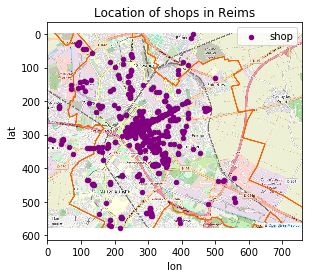

In [49]:
img = plt.imread("ReimsZoom.jpg")
fig, ax = plt.subplots()
ax.imshow(img)
df.plot(kind='scatter',x='lon',y='lat', title = 'Location of shops in Reims', label = 'shop', color='purple', ax = ax)
plt.show()

In [50]:
# Calculates the elapsed time
end_time = time.time()
print("Total elapsed time for chapters 3, 4 and 5: ", int(end_time - start_time), "seconds")

Total elapsed time for chapters 3, 4 and 5:  196 seconds


<a id='conclusion'></a>
## 6. Conclusion
Shortcut to chapters <a href='#introduction'>1</a>, <a href='#preparation'>2</a>, <a href='#wrangling'>3</a>, <a href='#sql'>4</a>, <a href='#analysis'>5</a> and <a href='#conclusion'>6</a>.  

After this review, we can conclude that the OpenStreetMap data is quite complete and cleaned for Reims city. I was curious about Reims city and I found out a few interesting results. So many results could have been retrieved from the data that I have limited them. It could be interesting to study other cities.

I have encountered a few difficulties during that analysis. If you could take time to provide me with some comments, it would be very appreciated.

**General difficulties:**  
* Find the right documentation depending on the Python version, the module version...
* Use of matplotlib.pyplot or plot function within Pandas modules

**Specific difficulties:**
* Automatic download of the OSM file. Why does not the code work properly?
* Cleaning of the data: directly in the OSM file, during the creation of CSV files or directly on CSV files using dataframe functions. What is the best step to clean the data? For instance, I correct the street and city names along with the postcode when I create the CSV files and I remove all entries with a postcode that does not match 51100.
* Use of the table schema validation with cerberus module. I had some difficulties to install cerberus package. By the way, what are the benefits against the code I used?